In [14]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(context='paper', 
        style='ticks', 
        font_scale=1,
        # add removing the right and top spines
        rc={'axes.spines.right': False, 
            'axes.spines.top': False,})

sns.set_palette('colorblind')

In [15]:
def get_ngram(query, start_year=1800, end_year=2019, 
            corpus='en-2019'):
    url = f'https://books.google.com/ngrams/json?content={query}&year_start={start_year}&year_end={end_year}&corpus={corpus}&smoothing=0'
    response = requests.get(url)
    data = response.json() 
    return data[0]['timeseries'] if data else None

In [16]:
nouns = ['pitcher_NOUN', 'carafe_NOUN', 'flagon_NOUN', 'ever_NOUN', 'jug_NOUN']

In [17]:
frequencies = [get_ngram(noun, start_year=1900) for noun in nouns]
# convert frequncies to relative frequencies
# frequencies = [np.array(freq) / np.sum(freq) for freq in frequencies]
frequencies = np.array(frequencies)
# divide by sum of each column
frequencies = frequencies / np.sum(frequencies, axis=0)
colors = sns.color_palette("husl", len(nouns))

/var/folders/1c/pphtjl397rnbdcp94xmwzkqr0000gn/T/ipykernel_39293/280970720.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


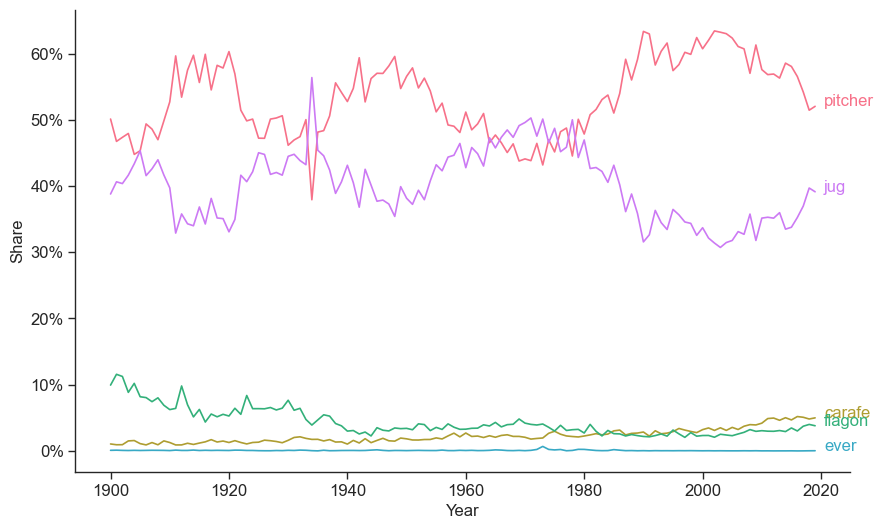

In [18]:
plt.figure(figsize=(10, 6))

for i, frequency in enumerate(frequencies):
    plt.plot(range(1900, 2020), frequency, color=colors[i])

# add labels at the end of the lines
for i, noun in enumerate(nouns):
    plt.text(2020.5, frequencies[i][-1], 
             noun.split('_')[0], color=colors[i], fontsize=12)
    
# convert y axis to percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])

# increase text size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Year', fontsize=12)
plt.ylabel('Share', fontsize=12)
sns.despine()
plt.show()